## Setting up

In [51]:
from math import sqrt, exp as mexp

# import numpy functions
from numpy import (
    vectorize, linspace, logspace, arange, zeros, log10, fill_diagonal, 
    exp, pi, set_printoptions, log2, inf, array, ndarray, diagonal,
    sin, cos, sinh, sqrt as nsqrt, log, sin, ones, finfo, meshgrid, where, union1d, 
    eye, count_nonzero
)
from scipy.sparse import diags as spdiags, eye as speye, kron as spkron
from scipy.sparse.linalg import spsolve
from numpy.linalg import solve, norm

from scipy.interpolate import interp2d


import sys

# set to print lines to large width
set_printoptions(linewidth=500)

from itertools import cycle

%matplotlib inline
from matplotlib.style import use
# use("seaborn")

# import the default plot settings
from pltconfig import *

from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.

In [52]:
class five_pt_laplacian(object):
    
    def __init__(
        self, m=4, n=4, a=0.0, b=1.0, c=0.0, d=3.0
        ):
        
        # assign input variables
        self.m = m
        self.a = a
        self.b = b
        self.n = n
        self.c = c
        self.d = d
        
        # compute derived variables
        # set up grid in x-direction
        self.Lx = b-a
        self.dx = self.Lx/(m+1)
        self.xpts = linspace(a, b, m+2)
        
        # set up grid in y-direction
        self.Ly = d-c
        self.dy = self.Ly/(n+1)
        self.ypts = linspace(c, d, n+2)
        
        self.xxn, self.yyn = meshgrid(self.xpts, self.ypts)
        # get the interior mesh
        self.xxv, self.yyv = self.xxn.flatten(), self.yyn.flatten()
        
        # get boundary conditions
        self.yl = ones(m)
        self.xt = 2*ones(m)
        self.yr = 3*ones(m)
        self.xb = 4*ones(m)
        
        # construct A matrix
        self.A = self.get_A()
        
        # construct F
        self.F = self.get_F()
        
        # get solution 
        self.U = self.get_soln()

    def get_A(self):
        
        """Get the A matrix on LHS with boundary conditions built in"""
        
        # unload the variables
        m = self.m
        a = self.a
        b = self.b
        dx = self.dx
        xxv = self.xxv
        
        n = self.n
        c = self.c
        d = self.d
        dy = self.dy
        yyv = self.yyv
        
        # define internal arrays
        onez = ones(max(m,n)+2)
        _internal = array([1, -2, 1])
        
        # set up differentiation matrix
        D2x = spdiags(_internal[:,None]*onez[None,:], [-1, 0, 1], (m+2,m+2))
        Ix = speye(m+2)
        
        D2y = spdiags(_internal[:,None]*onez[None,:], [-1, 0, 1], (n+2,n+2))
        Iy = speye(n+2)
        
        A = spkron(Iy, D2x)/(dx*dx) + spkron(D2y, Ix)/(dy*dy)
        
        # build in the boundary conditions
        bcxid = union1d(where(xxv==a),where(xxv==b))
        bcyid = union1d(where(yyv==c),where(yyv==d))
        bcids = union1d(bcxid, bcyid)
        nbcpts = bcids.size
        A[bcids,:] = zeros((nbcpts,(m+2)*(n+2)))
        A[bcids[:,None],bcids[None,:]] = eye(nbcpts)

        return A.tocsr() # ensure that matrix returned is sparse
    
    def get_F(self):
        
        a = self.a
        b = self.b
        xpts = self.xpts
        xxn = self.xxn
        xxv = self.xxv
        
        c = self.c
        d = self.d
        ypts = self.ypts
        yyn = self.yyn
        yyv = self.yyv
        
        # Impose BCs at x = a,b and at y = c,d
        
        f = ((xxn**2) + (yyn**2))*exp(xxn*yyn)
        
        ul = exp(c*xpts)
        ur = exp(d*xpts)
        f[:,0] = ul # @ y = c
        f[:,-1] = ur # @ y = d
        
        ut = exp(a*ypts)
        ub = exp(b*ypts)
        f[0,:] = ut # @ x = a
        f[-1,:] = ub # @ x = b        
        
        F = f.flatten()
        
        return F
    
    def get_soln(self):
        return spsolve(self.A, self.F).reshape((self.m+2,self.n+2))
    
    def exact_soln(self, x, y):
        return exp(x*y)
        
    def get_plot(self):
        
        fig = figure(figsize=(17,10))
        
        # check the mesh
        ax0 = fig.add_subplot(2, 3, 1)
        ax0.plot(self.xxv, self.yyv, "o", ms=14)
        ax0.set_ylim([self.c, self.d])
        ax0.set_xlim([self.a, self.b])
        ax0.set_xlabel(r"$x$", fontsize=18)
        ax0.set_ylabel(r"$y$", fontsize=18)
        ax0.set_title(
            f"Computational mesh: {self.m+2} x {self.n+2} = {self.xxv.size} points; dx = {self.dx}, dy = {self.dy}", 
            fontsize=13
            )
        
        # spy the matrix A
        ax1 = fig.add_subplot(2, 3, 2)
        ax1.spy(self.A)
        ax1.set_xlabel(f"nz = {count_nonzero(self.A.todense())}",fontsize=18)
        
        # plot the computed solution
        ax2 = fig.add_subplot(2, 3, 3, projection='3d')
        X, Y = meshgrid(self.xpts, self.ypts)
        ax2.plot_surface(X, Y, self.U)
        ax2.set_xlabel(r"$x$", fontsize=20)
        ax2.set_ylabel(r"$y$", fontsize=20)
        ax2.set_zlabel(r"$u$", fontsize=20)
        
        ax3 = fig.add_subplot(2, 3, 4)
        cs = ax3.contour(self.xpts, self.ypts, self.U, arange(2,21,2))
        ax3.clabel(cs)
        ax3.set_xlabel(r"$x$", fontsize=20)
        ax3.set_ylabel(r"$y$", fontsize=20)
        
        # interpolate solution on finer grid
        xxfine = linspace(self.a, self.b, 51)
        yyfine = linspace(self.c, self.d, 51)
        
        xxx, yyy = meshgrid(xxfine, yyfine)
        f = interp2d(self.xpts, self.ypts, self.U, kind="cubic")
        uuu = f(xxfine, yyfine)
        
        # find the inf-norm maximum error
        maxerr = norm(uuu-self.exact_soln(xxfine[:,None], yyfine[None,:]), ord=inf)
        
        ax4 = fig.add_subplot(2, 3, 5)
        cs2 = ax4.contour(xxfine, yyfine, uuu, arange(2,21,2))
        ax4.clabel(cs2)
        ax4.set_xlabel(r"$x$", fontsize=20)
        ax4.set_ylabel(r"$y$", fontsize=20)
        
        ax5 = fig.add_subplot(2, 3, 6, projection='3d')
        ax5.plot_surface(xxx, yyy, uuu)
        ax5.set_xlabel(r"$x$", fontsize=20)
        ax5.set_ylabel(r"$y$", fontsize=20)
        ax5.set_zlabel(r"$u$", fontsize=20)
        ax5.zaxis.set_label_position("top")
        ax5.set_title(f"Solution on fine grid; max. error = {maxerr:.4f}")
        
        fig.tight_layout()
        fig.subplots_adjust(right=0.98)
        fig.savefig("5pt_laplacian_example.pdf")

/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


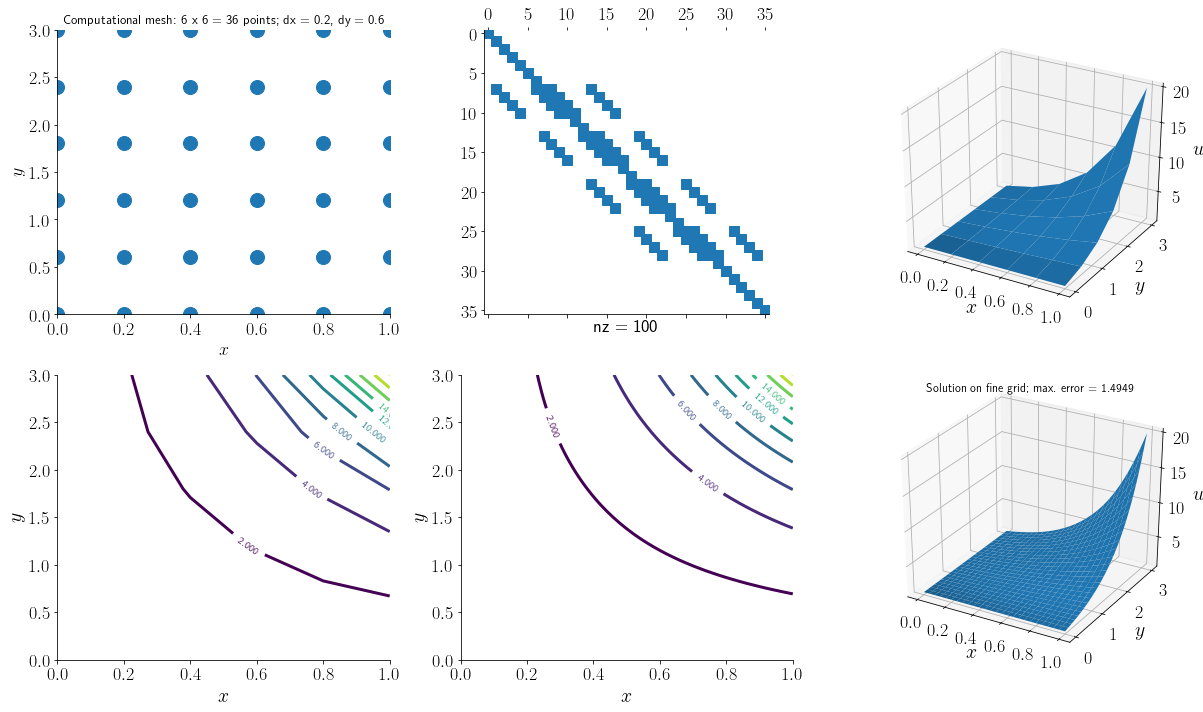

In [53]:
sample = five_pt_laplacian()
sample.get_plot()